## Imports modules

In [37]:
import numpy as np

# to get and read data
import os
import requests
import pickle

# to plot the data
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# for splitting data and evaluating results
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to track progress
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## get and read data

get data

In [2]:
# download zip

if not os.path.exists('anamoly_dataset.pickle'):
    url = 'https://drive.google.com/u/0/uc?id=1CdYxeX8g9wxzSnz6R51ELmJJuuZ3xlqa&export=download'
    r = requests.get(url, allow_redirects=True)
    open('anamoly_dataset.pickle', 'wb').write(r.content)
    print('file downloaded')
else:
    print('file already exists')

file downloaded


read data

In [25]:
infile = open('anamoly_dataset.pickle','rb')
data = pickle.load(infile)
infile.close()

features = 3
train_data = [ [ [input[:,i] for i in range(features) ], label ] for input,label in zip(data[0],data[1]) ]
test_data = [ [ [ input[:,i] for i in range(features) ], label ] for input,label in zip(data[2],data[3]) ]

train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

train_inputs = np.array(train_inputs)
test_inputs = np.array(test_inputs)

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

In [26]:
classes = ["normal","anamoly"]
print('number of classes :',len(classes))

print('\ntrain data contains',len(train_data),'samples')
print('test data contains',len(test_data),'samples')

print('\neach sample has 3 channels : x,y and force')
print('each channel is 50 in length')

number of classes : 2

train data contains 50000 samples
test data contains 10000 samples

each sample has 3 channels : x,y and force
each channel is 50 in length


function to plot sample

In [56]:
def plot_sample(sample):
    
    xVel  = sample[0]
    yVel  = sample[1]
    zVel  = sample[1]

    xPos  = np.cumsum(xVel)
    yPos  = np.cumsum(yVel)
    zPos  = np.cumsum(yVel)

    xPos  = np.insert(xPos[:-1],0,0)
    yPos  = np.insert(yPos[:-1],0,0) 
    zPos  = np.insert(yPos[:-1],0,0) 
    
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    #ax.plot3D(xPos, yPos, zPos)
    #ax.scatter3D(xPos, yPos, zPos)
    ax.quiver(xPos,yPos,zPos, xVel,yVel,zVel)

    plt.show()

visualize one sample of each class

normal


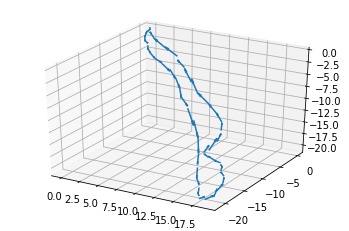

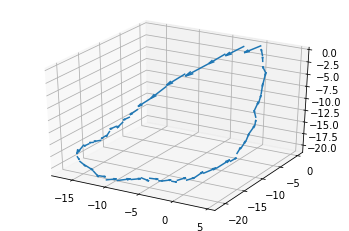

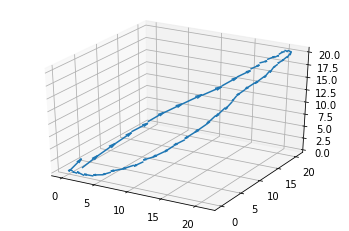

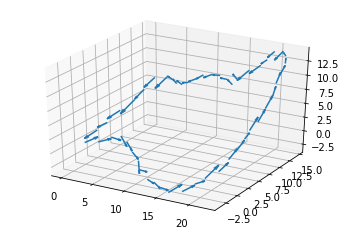

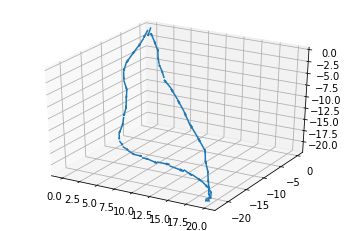

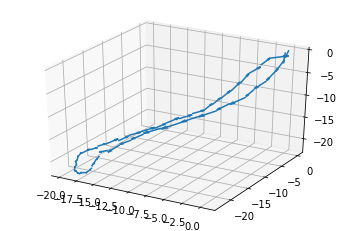

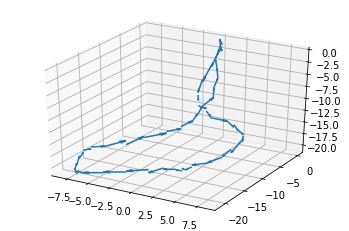

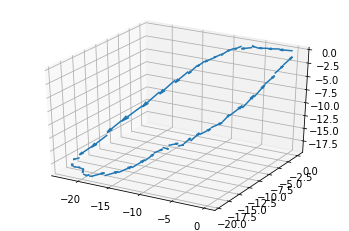

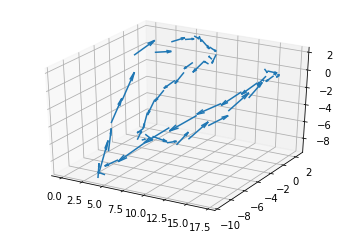

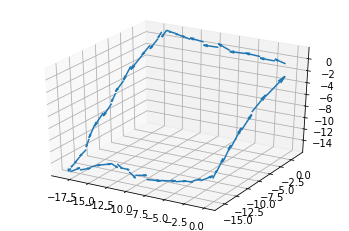

anamoly


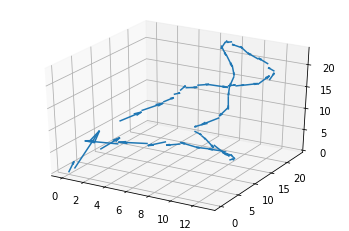

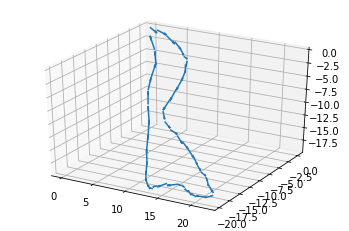

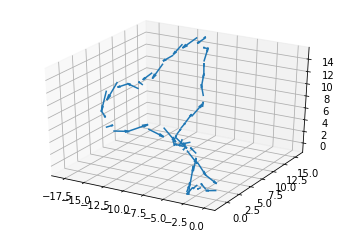

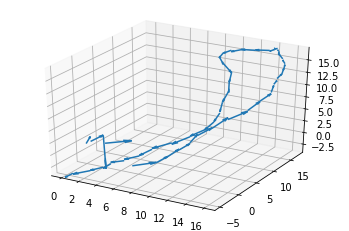

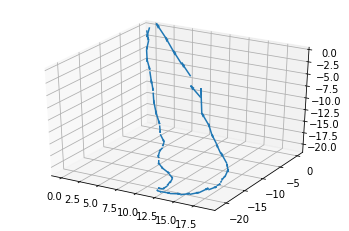

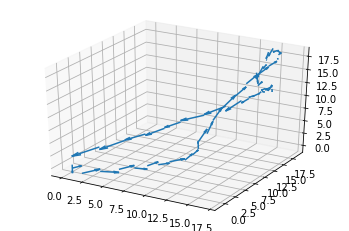

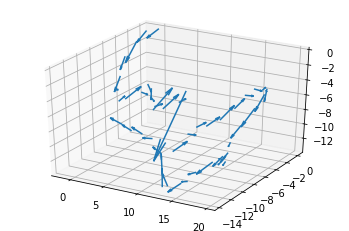

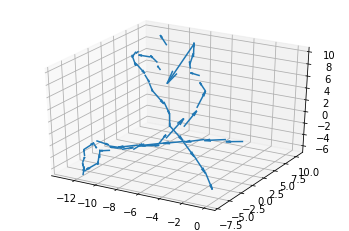

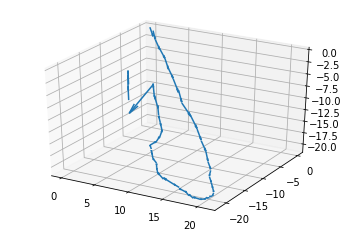

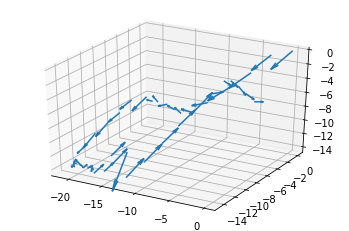

In [57]:
np.random.seed(0)
for i,class1 in enumerate(classes):
  print(class1)
  indexes = np.where(train_labels==i)[0]
  for _ in range(10):
    random_index = np.random.choice(indexes)
    plot_sample(train_inputs[random_index])

In [58]:
class mydataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = inputs
    self.labels = labels

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    input = self.inputs[index]
    label = self.labels[index]
    return input,label


train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)

train_dataset = mydataset(train_inputs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

val_dataset = mydataset(val_inputs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

test_dataset = mydataset(test_inputs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## define the network

In [82]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(3, 6, 3)
        self.conv2 = nn.Conv1d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(176, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net().to(device)

In [83]:
#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch: 5, train loss: 0.455, val loss: 0.451
epoch: 10, train loss: 0.411, val loss: 0.380
epoch: 15, train loss: 0.099, val loss: 0.098
epoch: 20, train loss: 0.079, val loss: 0.083
epoch: 25, train loss: 0.070, val loss: 0.078
epoch: 30, train loss: 0.066, val loss: 0.076
epoch: 35, train loss: 0.063, val loss: 0.075
epoch: 40, train loss: 0.060, val loss: 0.071
epoch: 45, train loss: 0.058, val loss: 0.069
epoch: 50, train loss: 0.056, val loss: 0.068

Finished Training


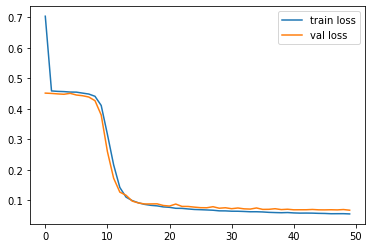

In [84]:
batch_avgTrainLoss = []
batch_avgValLoss = []

for epoch in tqdm(range(50)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []
    
    net.train()
    for i, (inputBatch,labelBatch) in enumerate(train_loader):
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss.append(loss.item())
    
    net.eval()
    for i, (inputBatch,labelBatch) in enumerate(val_loader):
      with torch.no_grad():
        
        inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
        inputBatch = inputBatch.float()

        # forward + backward + optimize
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        val_loss.append(loss.item())    
        
    avg_trainLoss = sum(train_loss) / len(train_loss)
    avg_valLoss = sum(val_loss) / len(val_loss)
    batch_avgTrainLoss.append(avg_trainLoss)
    batch_avgValLoss.append(avg_valLoss)

    # print statistics
    if epoch % 5 == 4:
      print('epoch: %d, train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_trainLoss, avg_valLoss))

print('Finished Training')
plt.plot(batch_avgTrainLoss, label='train loss')
plt.plot(batch_avgValLoss, label='val loss')
plt.legend()

evaluate

In [85]:
def evaluate(data_loader):
  y_true= []
  y_pred = []
  net.eval()

  for _, (inputBatch,labelBatch) in enumerate(data_loader):
    with torch.no_grad():
      inputBatch = inputBatch.float()
      labelBatch = labelBatch.type(torch.LongTensor)
      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)

      inputBatch, labelBatch = inputBatch.to(device), labelBatch.to(device)
      inputBatch = inputBatch.float()
      outputBatch = net(inputBatch)
      
      for output,label in zip(outputBatch,labelBatch):
        output, label = output.cpu(), label.cpu()
        y_true.append(label)
        pred = np.argmax(output)
        y_pred.append(pred)

  print(classification_report(y_true, y_pred, target_names=classes, digits=4))

In [86]:
print("evaluation results on train data")
evaluate(train_loader)
print("evaluation results on test data")
evaluate(test_loader)

evaluation results on train data
              precision    recall  f1-score   support

      normal     0.9874    0.9938    0.9906     31191
     anamoly     0.9682    0.9372    0.9525      6309

    accuracy                         0.9843     37500
   macro avg     0.9778    0.9655    0.9715     37500
weighted avg     0.9842    0.9843    0.9842     37500

evaluation results on test data
              precision    recall  f1-score   support

      normal     0.9859    0.9929    0.9894      8304
     anamoly     0.9640    0.9304    0.9469      1696

    accuracy                         0.9823     10000
   macro avg     0.9749    0.9617    0.9681     10000
weighted avg     0.9822    0.9823    0.9822     10000



function to return patch

In [ ]:
def patch(data,start,end,stride,channels):
  patch = []
  tmp = []

  l = len(data)
  np.random.seed(0)
  random_index = np.random.randint(l)
  sample = data[random_index]
  channels1 = sample[0]
  
  for i in channels:
    tmp1 = []
    for j in range(start,end,stride):
      tmp1.append(channels1[i][j])
    tmp.append(tmp1)    

  tmp = np.array(tmp)
  patch.append(tmp)
  patch.append(random_index)
  patch = np.array(patch)

  return patch

[[ 1.2739263   1.21741454 -1.01637009 -0.06684084 -1.8738427  -0.14069365
  -1.16032594  1.22731051]
 [-0.58926906 -0.15992613  0.54859623  0.15191093  0.46005668  0.16373539
   1.36509405 -0.03513964]]


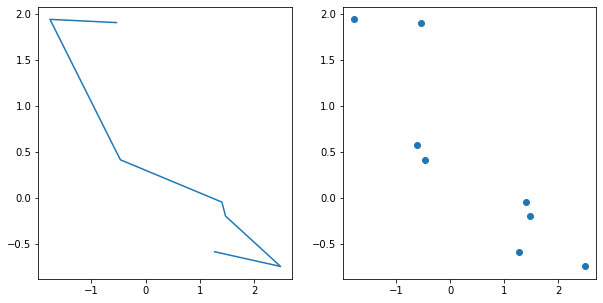

In [ ]:
sample_patch = patch(train_data, start=10, end=50, stride=5, channels=[0,1])
print(sample_patch[0])
plot_char(sample_patch[0])